In [1]:
#include <iostream>
#include <fstream>

In [2]:
/*

1. Reading the dataset

Structure of Open Data (dataset II):
- Data is stored in nTuples, i.e. 'trees'
- One event = one entry in the tree
- One variable = one 'branch' in the tree (branch = integers/floats/vectors/booleans etc.)
- All events have the same branches

*/

/*
TChain is used in order to link together data from several nTuples, i.e. it is a 'chain of trees' (forest?)
Would typically like one chain for real data and one for MC (background)
*/
TChain *background = new TChain("mini");
TChain *data = new TChain("mini");

In [3]:
TString sample; 
TString path; 
vector<Int_t> dataset_IDs;
Int_t DSID;

In [4]:
ifstream infile("../Input/8TeV/Background_samples.txt");

string name ;
/*
//checking names in file
while (!infile.fail() && !infile.eof() )
    {
          infile >> name;
          cout << name << endl;
    }
*/

In [5]:
infile.clear();
infile.seekg(0, ios::beg);  // Start at the beginning of the file
background->Reset(); // Reset the TChain (if necessary)
DSID = 0;

//while (!infile.fail() && !infile.eof() ){
while (infile >> sample >> DSID){
        path = "http://opendata.atlas.cern/release/samples/MC/"+sample;
        background->Add(path);
        dataset_IDs.push_back(DSID);
//        cout << "new run" << endl;
//        cout << DSID << endl;
//        cout << dataset_IDs[DSID] << endl;
//        DSID+=1;
}

In [6]:
/*
void print(const auto &input){
    for (int i; i<20; i++){
        cout << input[i] << endl;   
    }
}

print(dataset_IDs);
*/

In [7]:
data->Reset(); 
data->Add("http://opendata.atlas.cern/release/samples/Data/DataEgamma.root");
data->Add("http://opendata.atlas.cern/release/samples/Data/DataMuons.root");

In [8]:
//data->Print();
//background->Print();

In [9]:
//background->Scan("channelNumber");

In [10]:
/* 
Define variables wanted for the analysis and link them to branches in the TTree. Things to note:
1. In this example we will only study events with two leptons, so the vectorial variables only need 
   to be two dimensional.
2. The variables are here given names corresponding to the branches in the TTree. Not really necessary, can also 
   use other names.
3. The variable called "channelNumber" is the same as we have called "dataset ID" above. These terms are used 
   interchangeably. 
 */
Int_t lep_n, lep_charge[2], lep_type[2], channelNumber; 
Float_t lep_pt[2], lep_E[2], lep_phi[2], lep_eta[2], met_et, mcWeight, jet_MV1[10]; 
Bool_t passGRL, hasGoodVertex, trigE, trigM, lep_trigMatched[2]; 
Float_t lep_etcone20[2], lep_ptcone30[2]; 
Int_t lep_flag[2];

In [11]:
Float_t scaleFactor_PILEUP, scaleFactor_ELE, scaleFactor_MUON, scaleFactor_BTAG, scaleFactor_TRIGGER, scaleFactor_JVFSF, scaleFactor_ZVERTEX;

In [12]:
// For MC:  
background->SetBranchAddress("lep_n",      &lep_n);
background->SetBranchAddress("lep_charge", &lep_charge);
background->SetBranchAddress("lep_type",   &lep_type);
background->SetBranchAddress("lep_pt",     &lep_pt);
background->SetBranchAddress("lep_eta",    &lep_eta);
background->SetBranchAddress("lep_phi",    &lep_phi);
background->SetBranchAddress("lep_E",      &lep_E);
background->SetBranchAddress("met_et",     &met_et); 
background->SetBranchAddress("channelNumber", &channelNumber);
background->SetBranchAddress("mcWeight", &mcWeight); 
background->SetBranchAddress("scaleFactor_PILEUP", &scaleFactor_PILEUP ); 
background->SetBranchAddress("scaleFactor_ELE", &scaleFactor_ELE ); 
background->SetBranchAddress("scaleFactor_MUON", &scaleFactor_MUON ); 
background->SetBranchAddress("scaleFactor_BTAG", &scaleFactor_BTAG ); 
background->SetBranchAddress("scaleFactor_TRIGGER", &scaleFactor_TRIGGER ); 
background->SetBranchAddress("scaleFactor_JVFSF", &scaleFactor_JVFSF );
background->SetBranchAddress("scaleFactor_ZVERTEX", &scaleFactor_ZVERTEX ); 
background->SetBranchAddress("lep_flag", &lep_flag); 
background->SetBranchAddress("lep_ptcone30", &lep_ptcone30); 
background->SetBranchAddress("lep_etcone20", &lep_etcone20); 
background->SetBranchAddress("passGRL", &passGRL); 
background->SetBranchAddress("hasGoodVertex", &hasGoodVertex); 
background->SetBranchAddress("trigE", &trigE); 
background->SetBranchAddress("trigM", &trigM); 
background->SetBranchAddress("jet_MV1", &jet_MV1); 

// For data 
data->SetBranchAddress("lep_n",      &lep_n);
data->SetBranchAddress("lep_charge", &lep_charge);
data->SetBranchAddress("lep_type",   &lep_type);
data->SetBranchAddress("lep_pt",     &lep_pt);
data->SetBranchAddress("lep_eta",    &lep_eta);
data->SetBranchAddress("lep_phi",    &lep_phi);
data->SetBranchAddress("lep_E",      &lep_E);
data->SetBranchAddress("met_et",     &met_et); 
data->SetBranchAddress("channelNumber", &channelNumber);
data->SetBranchAddress("passGRL", &passGRL); 
data->SetBranchAddress("hasGoodVertex", &hasGoodVertex); 
data->SetBranchAddress("trigE", &trigE); 
data->SetBranchAddress("trigM", &trigM); 
data->SetBranchAddress("lep_trigMatched", &lep_trigMatched); 
data->SetBranchAddress("lep_flag", &lep_flag); 
data->SetBranchAddress("lep_ptcone30", &lep_ptcone30); 
data->SetBranchAddress("lep_etcone20", &lep_etcone20);
data->SetBranchAddress("jet_MV1", &jet_MV1);


In [13]:
/*

2. Analysis of data and obtaining the desired final states by cuts

*/

// Declaring map containing 1D histograms, in which each histogram contains values of type int_t.
map<Int_t, TH1*> hist_mll; 
map<Int_t, TH1*> hist_lep_pt; 
map<Int_t, TH1*> hist_met;

// Assign element i to each DSID in dataset_IDs. E.g. dataset_IDs = {1, 2, 3, 4, ...} -> i = {0, 1, 2, 3, 4, ...}
// such that map of hist_mll contains multiple histograms each corresponding to 1 tree/ background file.
for(const auto & i:dataset_IDs){
    hist_mll[i] = new TH1F(); 
    hist_lep_pt[i] = new TH1F(); 
    hist_met[i] = new TH1F();
//    cout << i << endl;
}

for(const auto & i:dataset_IDs){
    hist_mll[i]->SetNameTitle("hist_mll", "Invariant mass"); 
    hist_lep_pt[i]->SetNameTitle("hist_lep_pt", "Lepton pT"); 
    hist_met[i]->SetNameTitle("hist_met", "Missing ET");
    hist_mll[i]->SetBins(20,0,500); 
    hist_lep_pt[i]->SetBins(20,0,1000);
    hist_met[i]->SetBins(20,0,500); 
//    cout << i << endl;
}

In [14]:
hist_mll_d = new TH1F(); 
hist_lep_pt_d = new TH1F(); 
hist_met_d = new TH1F();

In [15]:
hist_mll_d->SetNameTitle("hist_mll", "Invariant mass"); 
hist_lep_pt_d->SetNameTitle("hist_lep_pt", "Lepton pT"); 
hist_met_d->SetNameTitle("hist_met", "Missing ET");
hist_mll_d->SetBins(20,0,500); 
hist_lep_pt_d->SetBins(20,0,1000);
hist_met_d->SetBins(20,0,500);

In [16]:
TLorentzVector l1, l2, dileptons;

In [17]:
TChain *dataset = new TChain("mini"); 
int isData; 
int nentries, j; 
Float_t W; 
int n_bjets;

j = 0;

In [18]:
/*
// Reset histograms (in case you have filled them before) 
for(const auto & i:dataset_IDs){ 
    hist_mll[i]->Reset(); 
    hist_lep_pt[i]->Reset(); 
    hist_met[i]->Reset();
}
*/

hist_mll_d->Reset(); 
hist_lep_pt_d->Reset(); 
hist_met_d->Reset(); 

// Loop through all events 
for(isData = 0; isData<2; isData++){          //Running over background and data separately

    if(isData == 1){ 
        nentries = data->GetEntries();
        dataset = data; 
        cout << "Running over data..." << endl; 
    }
    else {
        nentries = background->GetEntries();;
        dataset = background;      
        cout << "Running over background..." << endl; 
//        dataset->Print();
    }
//    cout << nentries << endl;
    //running over all events within data and background
    for (int i = 0; i < nentries; i++){
        if(i == 100){cout << "100 events processed" << endl;}
        if( i%1000000 == 0 && i>0){ cout << i/1000000 << " million events processed" << endl;}
        dataset->GetEntry(i); // We "pull out" the i'th entry in the chain. The variables are now 
                              // available through the names we have given them. 
        
        //if(!( i%100000==0)){ continue; }

        // Data quality cuts;
//        cout << "hello" << endl;
        if(passGRL == 0){ continue; }     //continue -> jumps to the next event whenever if statement is satisfied. In contrast to "break", it does not quit the loop.
        if(hasGoodVertex == 0){ continue; }
        //if(trigM == 0 && trigE == 0){ continue; } 

        // Require "good leptons": 
        // Isolasjonskutt
        if( lep_pt[0]/1000.0 < 25 ){ continue; }  //25 GeV = standard cut for triggers for good accuracy
        if( lep_etcone20[0]/lep_pt[0] > 0.15 ){ continue; }   //what is lep_etcone20?
        if( lep_ptcone30[0]/lep_pt[0] > 0.15 ){ continue; }   //what is lep_ptcone30?
        if( !(lep_flag[0] & 512) ){ continue; }    //what is lep_flag?

        if( lep_pt[1]/1000.0 < 25 ){ continue; }
        if( lep_etcone20[1]/lep_pt[1] > 0.15 ){ continue; }
        if( lep_ptcone30[1]/lep_pt[1] > 0.15 ){ continue; }
        if( !(lep_flag[1] & 512) ){ continue; }
        
        // Cut #1: Require (exactly) 2 leptons
        if(lep_n != 2){ continue; }
        // Cut #2: Require opposite charge
        if(lep_charge[0] == lep_charge[1]){ continue; }
        // Cut #3: Require same flavour (2 electrons or 2 muons)
        if(lep_type[0] != lep_type[1]){ continue; }

        // Set Lorentz vectors: 
        l1.SetPtEtaPhiE(lep_pt[0]/1000., lep_eta[0], lep_phi[0], lep_E[0]/1000.);
        l2.SetPtEtaPhiE(lep_pt[1]/1000., lep_eta[1], lep_phi[1], lep_E[1]/1000.);
        // Variables are stored in the TTree with unit MeV, so we need to divide by 1000 
        // to get GeV, which is a more practical and commonly used unit. 

        dileptons = l1 + l2;       

        if(isData == 1){
            hist_mll_d->Fill(dileptons.M());
            hist_lep_pt_d->Fill(l1.Pt());
            hist_lep_pt_d->Fill(l2.Pt()); 
            hist_met_d->Fill(met_et/1000);                       
        }
        else{    
            j++;
            W = mcWeight*scaleFactor_PILEUP*scaleFactor_ELE*scaleFactor_MUON*scaleFactor_BTAG*scaleFactor_TRIGGER*scaleFactor_JVFSF*scaleFactor_ZVERTEX; 
            //cout << channelNumber << endl;
            hist_mll[channelNumber]->Fill(dileptons.M(), W);
            hist_lep_pt[channelNumber]->Fill(l1.Pt(), W);
            hist_lep_pt[channelNumber]->Fill(l2.Pt(), W); 
            hist_met[channelNumber]->Fill(met_et/1000, W); 
            
        }
    }

}    
cout << "Done!" << endl;
cout << j << endl;


Running over background...
100 events processed
1 million events processed
2 million events processed
3 million events processed
4 million events processed
5 million events processed
6 million events processed
7 million events processed
8 million events processed
9 million events processed
10 million events processed
11 million events processed
12 million events processed
13 million events processed
14 million events processed
15 million events processed
16 million events processed
17 million events processed
18 million events processed
19 million events processed
20 million events processed
21 million events processed
22 million events processed
23 million events processed
24 million events processed
25 million events processed
26 million events processed
27 million events processed
28 million events processed
29 million events processed
30 million events processed
31 million events processed
32 million events processed
33 million events processed
34 million events processed
35 millio

In [19]:
/*

3. Scale and classify the histograms (MC only)

*/

/*
Make a new set of histograms, each corresponding to the different background categories, instead of the unique
dataset IDs. These histograms are made with the same range and binnings as above.
*/
map<TString, TH1*> H_mll; 
map<TString, TH1*> H_lep_pt; 
map<TString, TH1*> H_met;


In [20]:
vector<TString> Backgrounds;

In [21]:
Backgrounds = {"Higgs","Diboson", "Wjets", "DY", "singleTop", "ttbar", "Zjets"};   //what about gamma-gamma?
/*
Printing elements in vector Backgrounds:
Can be done by e.g.

for(int i=1; i<Backgrounds.size(); i++){
    cout << Backgrounds[i] << "\n";
}
(since the .size() function is called for every loop, then this method may be slower than the next one).

or
for(const auto & i:Backgrounds){
    cout << i << endl;
}
*/
//cout << Background[1] << endl;

In [22]:
for(const auto & i:Backgrounds){
//    cout << i << endl;
    H_mll[i] = new TH1F();
    H_lep_pt[i] = new TH1F(); 
    H_met[i] = new TH1F();
}

In [23]:
for(const auto & i:Backgrounds){
    H_mll[i]->SetNameTitle("hist_mll", "Invariant mass"); 
    H_lep_pt[i]->SetNameTitle("hist_lep_pt", "Lepton pT"); 
    H_met[i]->SetNameTitle("hist_met", "Missing ET");
    H_mll[i]->SetBins(20,0,500); 
    H_lep_pt[i]->SetBins(20,0,1000);
    H_met[i]->SetBins(20,0,500); 
}

In [24]:
/*
Read the information file (InfoFile.txt) containing the process, type, number of events recorded, efficiency etc.
Scale all (old) histograms and add them to the ones newly defined.
*/

ifstream info("../Input/8TeV/InfoFile.txt");
TString process; 
TString type; 
Int_t dsid; 
Int_t n_events; 
Double_t red_eff; // Efficiency  
Double_t sum_w; // Sum of weights 
Double_t x_sec; // Cross section 
Double_t L; // Integrated luminosity (pb)
Double_t SF; // Total scale factor

L = 1000.6;   //Integrated luminosity

In [25]:
for(const auto & i:Backgrounds){
    H_mll[i]->Reset();
    H_lep_pt[i]->Reset();
    H_met[i]->Reset();
}

In [26]:
info.clear();
info.seekg(0, ios::beg);
while(info >> process >> type >> dsid >> n_events >> red_eff >> sum_w >> x_sec){
    SF = x_sec*L/(sum_w*red_eff);

    // Normalization of histogram, i.e. where norm is the desired normalization divided by the integral of the 
    // histogram.
    hist_mll[dsid]->Scale(SF);
    hist_lep_pt[dsid]->Scale(SF); 
    hist_met[dsid]->Scale(SF); 
    
    H_mll[type]->Add(hist_mll[dsid]); 
    H_lep_pt[type]->Add(hist_lep_pt[dsid]); 
    H_met[type]->Add(hist_met[dsid]);
}

In [27]:
//Making new map containing the colours wanted for each background process, and set the colours of the histogram

map<TString, Int_t> colors;

colors["Diboson"] = kGreen; 
colors["Zjets"] = kYellow; 
colors["ttbar"] = kRed;
colors["singleTop"] = kBlue-7; 
colors["Wjets"] = kBlue+3; 
colors["DY"] = kOrange+1; 
colors["Higgs"] = kMagenta;

for(const auto h:Backgrounds){
    H_mll[h]->SetFillColor(colors[h]); 
    H_met[h]->SetFillColor(colors[h]);
    H_lep_pt[h]->SetFillColor(colors[h]);
    
    H_mll[h]->SetLineColor(colors[h]); 
    H_met[h]->SetLineColor(colors[h]);
    H_lep_pt[h]->SetLineColor(colors[h]);
}


In [28]:
/*

4. Stack and plot the histograms

For each variable we need to stack the backgrounds on top of each other, which is done by using the THStack class. 
In the example below we do this for two variables; invariant mass and missing ET.

*/

THStack *stack_mll = new THStack("Invariant mass", "");
THStack *stack_met = new THStack("Missing ET", ""); 
THStack *stack_lep_pt = new THStack("Lepton pT", "");

for(const auto h:Backgrounds){
    stack_mll->RecursiveRemove(H_mll[h]); // Remove previously stacked histograms  
    stack_met->RecursiveRemove(H_met[h]);
    stack_lep_pt->RecursiveRemove(H_lep_pt[h]);
    stack_mll->Add(H_mll[h]); //Add new stacked histograms
    stack_met->Add(H_met[h]);
    stack_lep_pt->Add(H_lep_pt[h]); 
}


In [29]:
gStyle->SetLegendBorderSize(0); // Remove (default) border around legend
TLegend *leg = new TLegend(0.65, 0.60, 0.9, 0.85);

In [30]:
leg->Clear();
for(const auto i:Backgrounds){
    leg->AddEntry(H_mll[i], i, "f");  // Add your histograms to the legend
}
leg->AddEntry(hist_mll_d, "Data", "lep");

In [31]:
TCanvas *C = new TCanvas("c", "c", 600, 600);
gPad->SetLogy(); // Set logarithmic y-axis

In [32]:
hist_mll_d->SetLineColor(kBlack);
hist_mll_d->SetMarkerStyle(kFullCircle);
hist_mll_d->SetMarkerColor(kBlack);

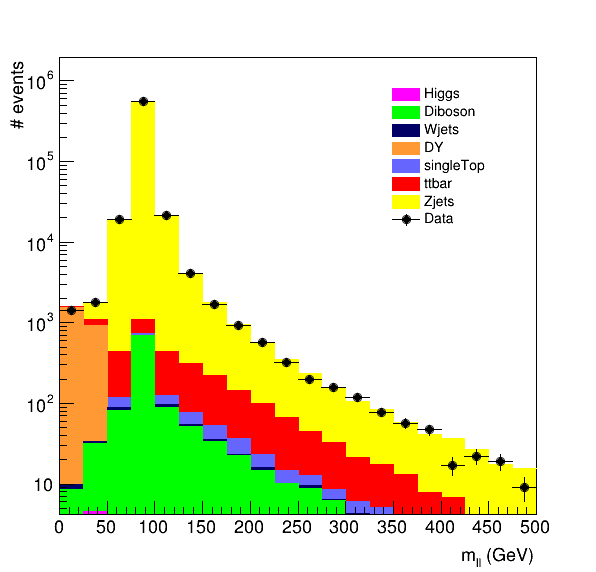

Info in <TCanvas::Print>: pdf file OpenData_mll_dileptons.pdf has been created


In [33]:
stack_mll->Draw("hist");
stack_mll->SetMaximum(1E6);     //set maximum range on axis
stack_mll->GetYaxis()->SetTitle("# events");
stack_mll->GetYaxis()->SetTitleOffset(1.3);
stack_mll->GetXaxis()->SetTitle("m_{ll} (GeV)");
stack_mll->GetXaxis()->SetTitleOffset(1.3);
hist_mll_d->Draw("same E");
leg->Draw();
C->Draw();
C->SaveAs("OpenData_mll_dileptons.pdf", "pdf")

/*
If there are less statistics, i.e. less number of events such as 10-20 events, then it is more likely that the MC
samples and real data will differ as the MC predicts the amount of events one can expect at a certain range of e.g.
m_ll. As long as the number of events of MC and real data do not differ too much at high statistics, e.g. 10^6 events,
then MC is correct. If they do, then there is something wrong with the theory modelling the MC.
*/

In [34]:
//int nEntries_data = data->GetEntries();

In [35]:
//hist_mll->GetBinContent();

In [36]:
hist_met_d->SetLineColor(kBlack);
hist_met_d->SetMarkerStyle(kFullCircle);
hist_met_d->SetMarkerColor(kBlack);

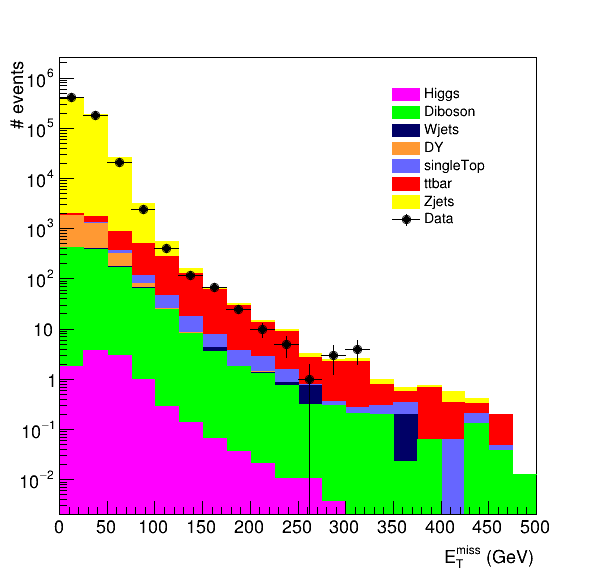

In [37]:
stack_met->Draw("hist"); 
stack_met->SetMaximum(1E6);
stack_met->SetMinimum(1E-2); 
stack_met->GetYaxis()->SetTitle("# events");
stack_met->GetYaxis()->SetTitleOffset(1.3); 
stack_met->GetXaxis()->SetTitle("E_{T}^{miss} (GeV)");
stack_met->GetXaxis()->SetTitleOffset(1.3);
hist_met_d->Draw("same e"); 
leg->Draw();
C->Draw();

/*
Often more difficult to model E_miss
*/

In [38]:
hist_lep_pt_d->SetLineColor(kBlack); 
hist_lep_pt_d->SetMarkerStyle(kFullCircle); 
hist_lep_pt_d->SetMarkerColor(kBlack);

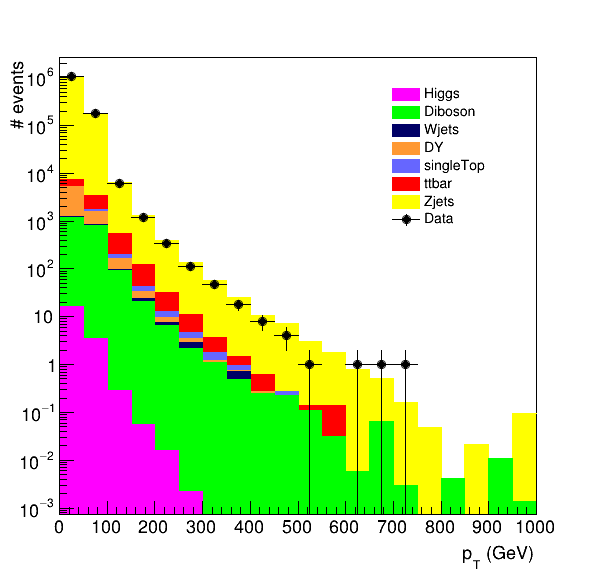

In [39]:
stack_lep_pt->Draw("hist"); 
stack_lep_pt->SetMaximum(1E6); 
stack_lep_pt->GetYaxis()->SetTitle("# events");
stack_lep_pt->GetYaxis()->SetTitleOffset(1.3); 
stack_lep_pt->GetXaxis()->SetTitle("p_{T} (GeV)");
stack_lep_pt->GetXaxis()->SetTitleOffset(1.3);
hist_lep_pt_d->Draw("same e"); 
leg->Draw();
C->Draw();

/*
natural to also include ratio of events between data/MC --> Add another pad to the canvas including this!
*/

In [40]:
cout << j << endl;

6686731
